# Task 2: Experimentation and uplift testing


## the email: 

Hi, 

Thanks for your feedback earlier, I’m glad you find my follow up emails helpful in ensuring your on the right track.

For this part of the project we will be examining the performance in trial vs control stores to provide a recommendation for each location based on our insight. Below are some of the areas I want you to focus on, of course if you discover any other interesting insights feel free to include them in your findings.

Select control stores – explore the data and define metrics for your control store selection – think about what would make them a control store. Look at the drivers and make sure you visualise these in a graph to better determine if they are suited. For this piece it may even be worth creating a function to help you. 

Assessment of the trial – this one should give you some interesting insights into each of the stores, check each trial store individually in comparison with the control store to get a clear view of its overall performance. We want to know if the trial stores were successful or not. 

Collate findings – summarise your findings for each store and provide an recommendation that we can share with Julia outlining the impact on sales during the trial period.

Remember when working with a client visualisations are key to helping them understand the data. Be sure to save all your visualisations so we can use them later in our report. We are presenting to our client in 3 weeks so if you could submit your analysis by mid next week that will give us great amount of time to discuss findings and pull together the report.

Keep up the good work!

Thanks, 

Zilinka'

## Task overview

Julia has asked us to evaluate the performance of a store trial which was performed in stores 77, 86 and 88. 

step 1: select control store

    - look at stores that have similar performance to the trial store

    - metrics: monthly overall sales revenue, monthly number of customers and monthly number of transactions per customer.

    - only consider stores that have sales over every month over the selected period ( july 2018 -> June 2019)

Step 2: Rank how similar each potential control store is to the trial store

    - 1st mthd: how correlated the store performances are

    - 2nd methd: a combination metric that consider how diff each cntrl store to the trial store on monthly basis


Step 3: Asses the impact of the trial on sales

    - check if the trial stores have significantly different results to the control store

## Step 1: 📊

**Select control stores**

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :

• Monthly overall sales revenue

• Monthly number of customers

• Monthly number of transactions per customer

In [69]:
import pandas as pd
import numpy as np

# Data Loading and Preprocessing
df = pd.read_csv('QVI_data.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH'] = df['DATE'].dt.to_period('M')

# Grouping by STORE_NBR and MONTH
store_monthly_summary = df.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    total_customers=('LYLTY_CARD_NBR', 'nunique'),
    total_transactions=('TXN_ID', 'nunique')
).reset_index()

# Calculating average transactions per customer
store_monthly_summary['avg_transactions_per_customer'] = (
    store_monthly_summary['total_transactions'] / store_monthly_summary['total_customers']
)

# Filtering for stores with full data (July 2018 to June 2019)
all_months = pd.date_range('2018-07-01', '2019-06-30', freq='MS').to_period('M')
valid_stores = store_monthly_summary.groupby('STORE_NBR')['MONTH'].nunique()
valid_stores = valid_stores[valid_stores == len(all_months)].index

store_monthly_summary = store_monthly_summary[
    store_monthly_summary['STORE_NBR'].isin(valid_stores)
]

# Focusing on pre-trial months: July 2018 – February 2019
pre_trial_months = pd.date_range('2018-07-01', '2019-01-31', freq='MS').to_period('M')
pre_trial_data = store_monthly_summary[
    store_monthly_summary['MONTH'].isin(pre_trial_months)
]

# Focus on the trial stores (example: store numbers 77, 86, 88)
trial_stores_df = pre_trial_data[pre_trial_data['STORE_NBR'].isin([77, 86, 88])]
trial_stores_df = trial_stores_df.sort_values(by=['MONTH', 'STORE_NBR'])

In [91]:
print('the number of stores in the pre_trial period:', pre_trial_data['STORE_NBR'].nunique())

the number of stores in the pre_trial period: 260


In [92]:
trial_stores_df.head(10)

,STORE_NBR,MONTH,total_sales,total_customers,total_transactions,avg_transactions_per_customer
880,77,2018-07,296.80,51,55,1.078431
977,86,2018-07,892.20,99,126,1.272727
1001,88,2018-07,1310.00,129,153,1.186047
881,77,2018-08,255.50,47,48,1.021277
978,86,2018-08,764.05,94,110,1.170213
1002,88,2018-08,1323.80,131,158,1.206107
882,77,2018-09,225.20,42,44,1.047619
979,86,2018-09,914.60,103,128,1.242718
1003,88,2018-09,1423.00,124,157,1.266129
883,77,2018-10,204.50,37,38,1.027027


## Step 2: 📊 Comparing Trial Stores to Other Stores During Trial Period
### Selecting the control stores

Now we need to work out a way of ranking how similar each potential control store is to the trial store. 

We
can calculate how correlated the performance of each store is to the trial store.
Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair

In [93]:
import numpy as np
import pandas as pd

# Ensure pre_trial_data is correctly loaded
# pre_trial_data should already be defined from your earlier processing

def calculate_similarity(trial_df, control_df, metric):
    """Calculate correlation and magnitude distance for a specific metric."""
    trial_metric = trial_df[metric].values
    control_metric = control_df[metric].values

    if len(trial_metric) != len(control_metric):
        return np.nan, np.nan

    correlation = np.corrcoef(trial_metric, control_metric)[0, 1]
    magnitude_distance = np.mean(np.abs(trial_metric - control_metric))

    return correlation, magnitude_distance

This function calculates correlation (how closely the trends in the trial store’s metric match those of the control store) and magnitude distance (the absolute difference in values between the trial and control stores for that metric). 

Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.


#### Composite Score Calculation

We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.
Let’s take a simple average of the correlation and magnitude scores for each driver.

In [94]:
def calculate_composite_score(corr_sales, mag_sales_std, corr_customers, mag_customers_std):
    """Combine correlation (weighted 0.5) and standardized magnitude into final score."""
    sales_score = (0.5 * corr_sales + (1 - mag_sales_std)) / 2
    customers_score = (0.5 * corr_customers + (1 - mag_customers_std)) / 2
    return (sales_score + customers_score) / 2

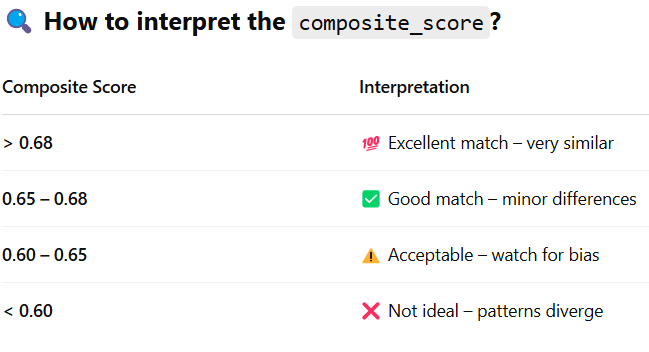

#### Comparaison of Sales Performance

We’ll need to combine the all the scores calculated using our function to create a composite score to rank
on.

Let’s take a simple average of the correlation and magnitude scores for each driver. 

! **Note**: if we consider
it more important for the trend of the drivers to be similar, we can increase the weight of the correlation
score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the
drivers to be more important, we can lower the weight of the correlation score.

Now we have a score for each of total number of sales and number of customers. Let’s combine the two
via a simple average.


In [95]:
def compare_trial_to_controls(trial_store_nbr, pre_trial_data):
    """Compare a trial store to all other stores and compute similarity scores."""
    trial_df = pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store_nbr]
    other_stores = pre_trial_data['STORE_NBR'].unique()
    other_stores = other_stores[other_stores != trial_store_nbr]

    rows = []

    for control_store in other_stores:
        control_df = pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]

        # Raw similarity metrics
        corr_sales, mag_sales = calculate_similarity(trial_df, control_df, 'total_sales')
        corr_customers, mag_customers = calculate_similarity(trial_df, control_df, 'total_customers')

        rows.append({
            'trial_store': trial_store_nbr,
            'control_store': control_store,
            'corr_sales': corr_sales,
            'mag_sales': mag_sales,
            'corr_customers': corr_customers,
            'mag_customers': mag_customers
        })

    df = pd.DataFrame(rows)

    # Standardize magnitude distances (min-max scaling per metric)
    df['mag_sales_std'] = (df['mag_sales'] - df['mag_sales'].min()) / (df['mag_sales'].max() - df['mag_sales'].min())
    df['mag_customers_std'] = (df['mag_customers'] - df['mag_customers'].min()) / (df['mag_customers'].max() - df['mag_customers'].min())

    # Compute composite scores using standardized magnitude distances
    df['composite_score'] = df.apply(
        lambda row: calculate_composite_score(
            row['corr_sales'],
            row['mag_sales_std'],
            row['corr_customers'],
            row['mag_customers_std']
        ),
        axis=1
    )

    return df

### Running the Comparison
After defining this function, we can run the comparison for all trial stores and get the final ranking based on the composite score:

In [96]:
# List of all trial stores
trial_store_numbers = [77,86,88]

# Initialize a list to collect results for each trial store
top_5_control_stores = []

for trial_store in trial_store_numbers:
    # Get similarity scores for the current trial store
    trial_scores = compare_trial_to_controls(trial_store, pre_trial_data)

    # Sort by composite score and get top 5 similar control stores
    top_5 = trial_scores.sort_values(by='composite_score', ascending=False).head(5)

    # Add top 5 control stores to the results list
    top_5_control_stores.append(top_5[['trial_store', 'control_store', 'composite_score']])

# Combine all the top 5 stores for each trial store into one DataFrame
top_5_stores_df = pd.concat(top_5_control_stores)

# Print the final DataFrame with trial stores and their top 5 similar control stores
top_5_stores_df

,trial_store,control_store,composite_score
220,77,233,0.736766
38,77,41,0.693283
15,77,17,0.662562
240,77,254,0.654890
107,77,115,0.654350
146,86,155,0.727336
101,86,109,0.689968
106,86,114,0.674632
129,86,138,0.663721
212,86,225,0.662207


We will pick the top-scoring store for each trial stores, based on the scores bellow here are the selected ones:

- **Trial store 77 -> store 233**
- **Trial store 86 -> store 155**
- **Trial store 88 -> store 237**

### Visualizing the trends between the trial stores and the selected control stores

Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period
before the trial.


In [78]:
import matplotlib.pyplot as plt

def plot_trial_vs_control(store_monthly_summary, trial_store, control_stores, metric, pre_trial_months):
    """
    Plots a comparison of the trial store and control stores for a specific metric (e.g., total_sales or total_customers).
    """
    plt.figure(figsize=(10, 6))
    
    # Filter data for the trial store and the control stores
    df_plot = store_monthly_summary[store_monthly_summary['STORE_NBR'].isin([trial_store] + control_stores)]
    
    # Filter data for the pre-trial months
    df_plot = df_plot[df_plot['MONTH'].isin(pre_trial_months)]
    
    # Plot the trial store
    trial_data = df_plot[df_plot['STORE_NBR'] == trial_store]
    plt.plot(trial_data['MONTH'].astype(str), trial_data[metric], label=f"Trial Store {trial_store}", marker='o', linestyle='-', color='blue')
    
    # Plot each control store
    for control_store in control_stores:
        control_data = df_plot[df_plot['STORE_NBR'] == control_store]
        plt.plot(control_data['MONTH'].astype(str), control_data[metric], label=f"Control Store {control_store}", marker='x', linestyle='--')
    
    # Customize plot
    plt.title(f"Comparison of {metric.replace('_', ' ').title()} - Trial Store {trial_store} vs Control Stores")
    plt.xlabel('Month')
    plt.ylabel(f'{metric.replace("_", " ").title()}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [80]:
# Define the pre-trial months (before February 2019)
pre_trial_months = pd.date_range('2018-07-01', '2019-01-31', freq='MS').to_period('M')


**Trial Store 77**


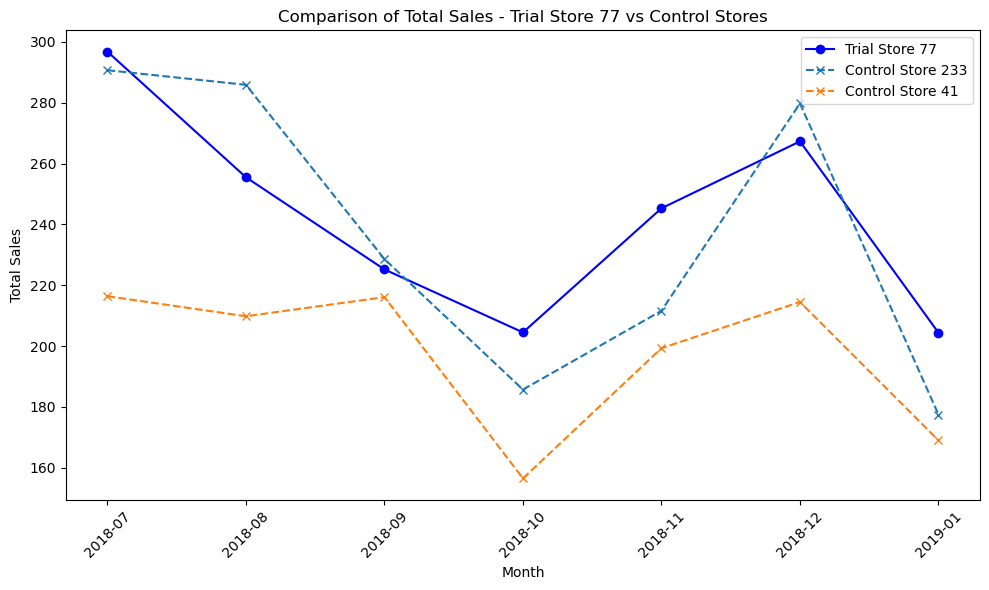

In [82]:
# Example usage for total sales of trial store 77 vs control stores [233,41,17]
plot_trial_vs_control(store_monthly_summary, trial_store=77, control_stores=[233,41], metric='total_sales', pre_trial_months=pre_trial_months)


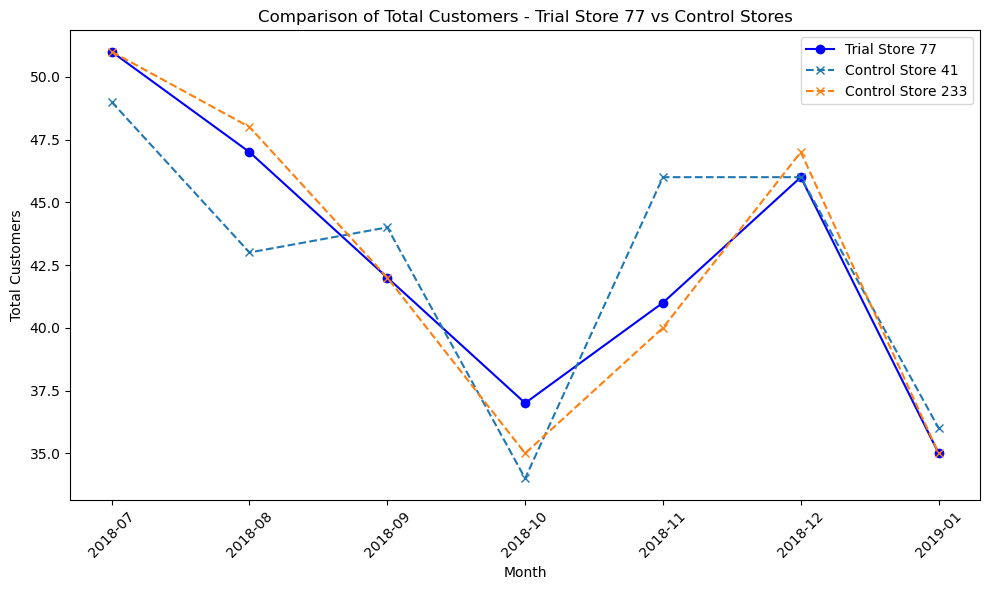

In [83]:
# Example usage for total customers of trial store 77 vs control stores [41, 159]
plot_trial_vs_control(store_monthly_summary, trial_store=77, control_stores=[41,  233], metric='total_customers', pre_trial_months=pre_trial_months)


**Trial Store 86**

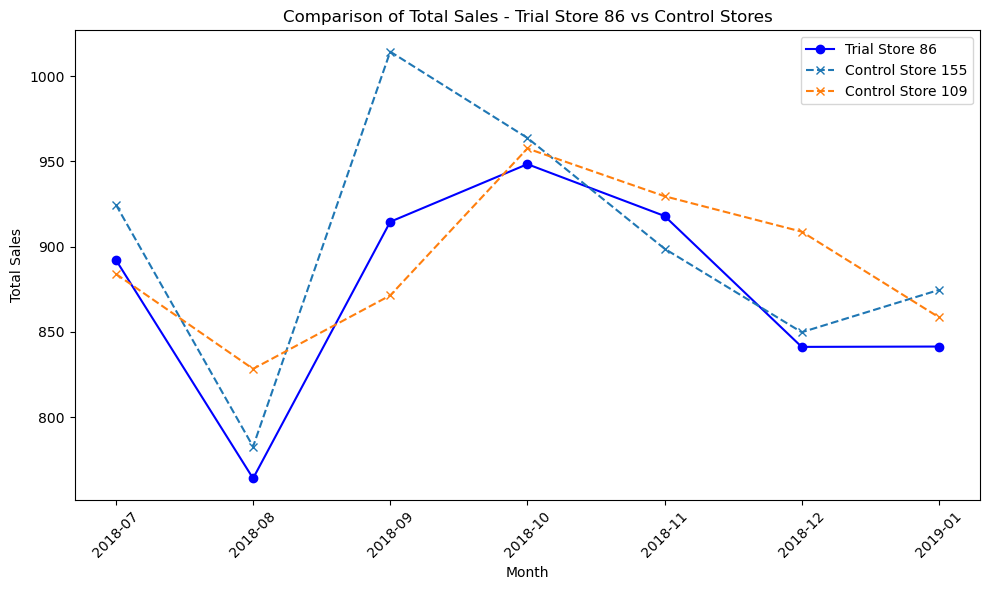

In [86]:
# Example usage for total sales of trial store 86 vs control stores [155,109]
plot_trial_vs_control(store_monthly_summary, trial_store=86, control_stores=[155,109], metric='total_sales', pre_trial_months=pre_trial_months)

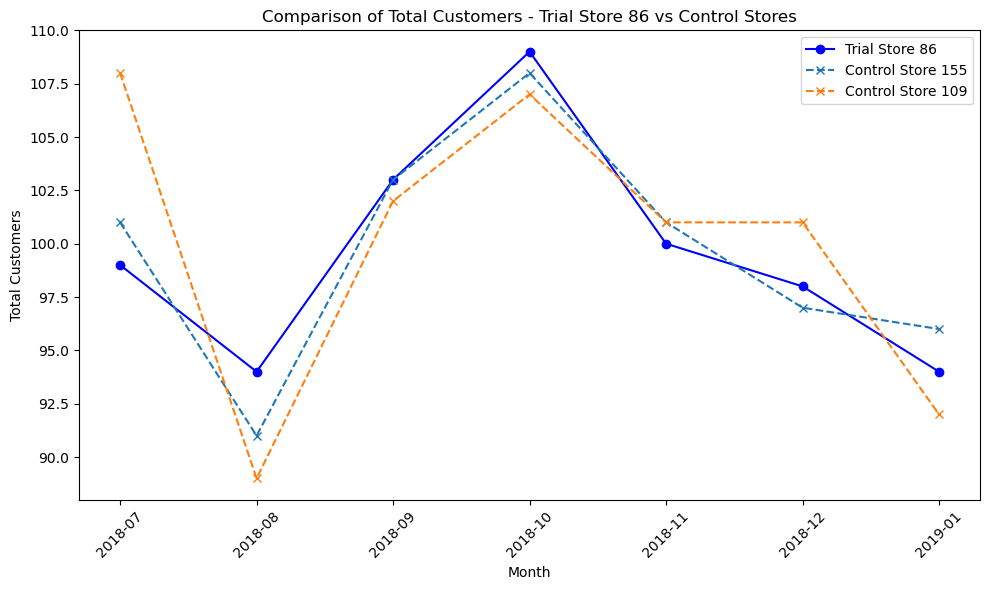

In [87]:
# Example usage for total sales of trial store 86 vs control stores [229,147,109]
plot_trial_vs_control(store_monthly_summary, trial_store=86, control_stores=[155,109], metric='total_customers', pre_trial_months=pre_trial_months)

**Trial Store 88**

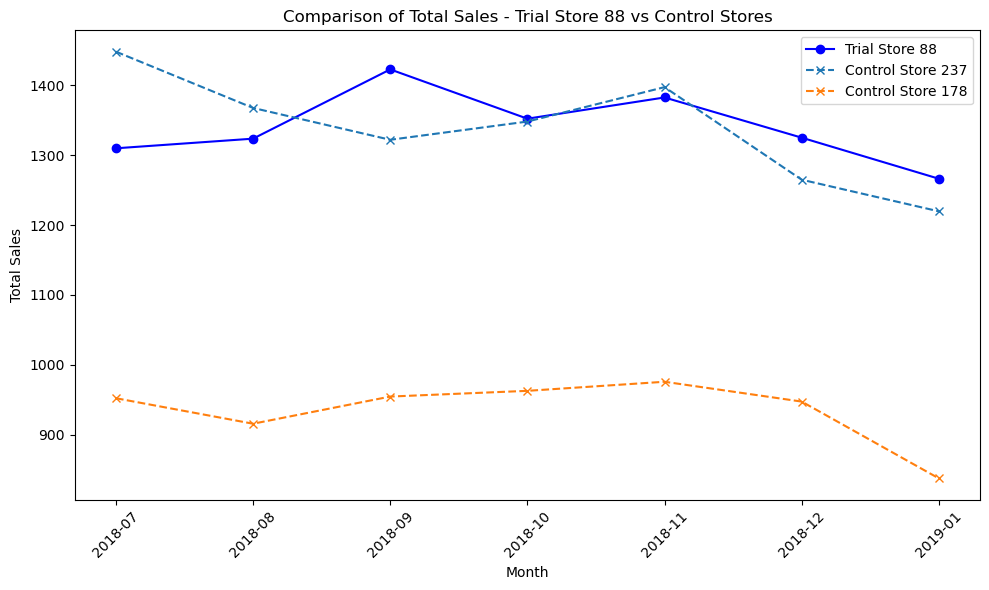

In [88]:
# Example usage for total sales of trial store 88 vs control stores [237,178]
plot_trial_vs_control(store_monthly_summary, trial_store=88, control_stores=[237,178], metric='total_sales', pre_trial_months=pre_trial_months)

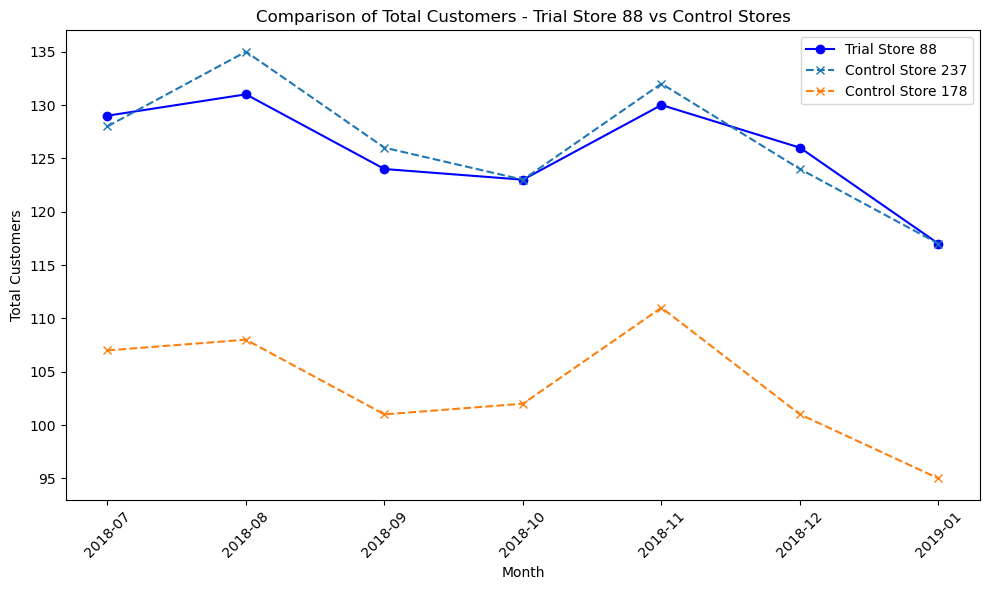

In [90]:
# Example usage for total sales of trial store 88 vs control stores [201,26,178]
plot_trial_vs_control(store_monthly_summary, trial_store=88, control_stores=[237,178], metric='total_customers', pre_trial_months=pre_trial_months)

## Step 3: Asses the impact of the trial on sales

### Scaling the control store

The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an
uplift in overall chip sales.
We’ll start with scaling the control store’s sales to a level similar to control for any differences between the
two stores outside of the trial period.

🔍 **Why Scale?**

Even before the trial starts, stores can have different levels of sales due to:Location (urban vs rural), Store size or popularity, Customer demographics, Store management or layout, Local competition, etc.

✅ **What Scaling Does**
Scaling adjusts the control store's sales proportionally, using the pre-trial period as a reference.

So we do this:

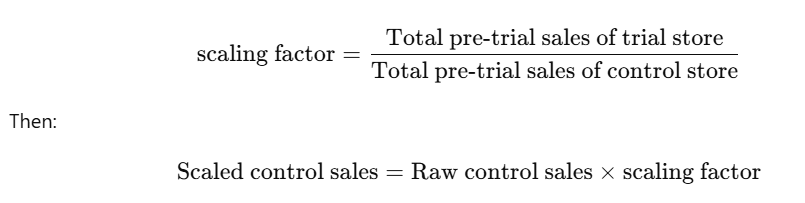

Now the control store’s sales mimic the baseline level of the trial store — which means any difference during the trial period is more likely due to the trial effect (e.g., a marketing campaign, layout change, etc.), not pre-existing differences.

In [141]:
import pandas as pd

# Define trial and pre-trial period months
trial_months = pd.date_range('2019-03-01', '2019-06-01', freq='MS').to_period('M')
pre_trial_months = pd.date_range('2018-07-01', '2019-01-31', freq='MS').to_period('M')

# Final DataFrame to collect trial vs control comparisons
trial_vs_control_sales = []

# Get top control store for each trial store
top_control_stores = top_5_stores_df.sort_values(['trial_store', 'composite_score'], ascending=[True, False])
top_control_stores = top_control_stores.groupby('trial_store').first().reset_index()

# Loop through each trial store
for _, row in top_control_stores.iterrows():
    trial_store = row['trial_store']
    control_store = row['control_store']

    # Get sales data
    trial_sales = store_monthly_summary[store_monthly_summary['STORE_NBR'] == trial_store]
    control_sales = store_monthly_summary[store_monthly_summary['STORE_NBR'] == control_store]

    # Pre-trial period
    trial_pre = trial_sales[trial_sales['MONTH'].isin(pre_trial_months)]
    control_pre = control_sales[control_sales['MONTH'].isin(pre_trial_months)]

    # Scaling factor (based on pre-trial period)
    scaling_factor = trial_pre['total_sales'].sum() / control_pre['total_sales'].sum()

    # Trial period data
    trial_during = trial_sales[trial_sales['MONTH'].isin(trial_months)][['MONTH', 'total_sales']].copy()
    control_during = control_sales[control_sales['MONTH'].isin(trial_months)][['MONTH', 'total_sales']].copy()

    # Rename columns
    trial_during.rename(columns={'total_sales': 'trial_sales'}, inplace=True)
    control_during.rename(columns={'total_sales': 'control_sales'}, inplace=True)
    control_during['scaled_control_sales'] = control_during['control_sales'] * scaling_factor

    # Merge into single row per month
    merged = pd.merge(trial_during, control_during, on='MONTH')
    merged['trial_store'] = trial_store
    merged['control_store'] = control_store

    # Calculate percentage difference: ((Trial - Scaled Control) / Scaled Control) * 100
    merged['perc_diff'] = ((merged['trial_sales'] - merged['scaled_control_sales']) / merged['scaled_control_sales']) * 100

    trial_vs_control_sales.append(merged)

# Combine into final dataframe
trial_vs_control_df = pd.concat(trial_vs_control_sales)
trial_vs_control_df.sort_values(by=['trial_store', 'MONTH'], inplace=True)

# Display results
trial_vs_control_df

# rearranging columns display
trial_vs_control_df = trial_vs_control_df[['MONTH','trial_store', 'control_store',  'trial_sales', 'scaled_control_sales','control_sales', 'perc_diff']]
trial_vs_control_df.reset_index(drop=True, inplace=True)
trial_vs_control_df


,MONTH,trial_store,control_store,trial_sales,scaled_control_sales,control_sales,perc_diff
0,2019-03,77.0,233.0,278.50,203.802205,199.10,36.652103
1,2019-04,77.0,233.0,263.50,162.345704,158.60,62.307960
2,2019-05,77.0,233.0,299.30,352.533799,344.40,-15.100339
3,2019-06,77.0,233.0,264.70,226.219424,221.00,17.010288
4,2019-03,86.0,155.0,1026.80,780.320405,804.40,31.586973
5,2019-04,86.0,155.0,848.20,819.317024,844.60,3.525250
6,2019-05,86.0,155.0,889.30,895.224622,922.85,-0.661803
7,2019-06,86.0,155.0,838.00,831.539845,857.20,0.776891
8,2019-03,88.0,237.0,1477.20,1210.082775,1208.20,22.074294
9,2019-04,88.0,237.0,1439.40,1206.477165,1204.60,19.306029


In [155]:
import pandas as pd

# Define trial and pre-trial period months
trial_months = pd.date_range('2019-03-01', '2019-06-01', freq='MS').to_period('M')
pre_trial_months = pd.date_range('2018-07-01', '2019-01-31', freq='MS').to_period('M')

# Final DataFrame to collect trial vs control comparisons
trial_vs_control_sales = []

# Get top control store for each trial store
top_control_stores = top_5_stores_df.sort_values(['trial_store', 'composite_score'], ascending=[True, False])
top_control_stores = top_control_stores.groupby('trial_store').first().reset_index()

# Loop through each trial store
for _, row in top_control_stores.iterrows():
    trial_store = row['trial_store']
    control_store = row['control_store']

    # Get sales data
    trial_sales = store_monthly_summary[store_monthly_summary['STORE_NBR'] == trial_store]
    control_sales = store_monthly_summary[store_monthly_summary['STORE_NBR'] == control_store]

    # Pre-trial period
    trial_pre = trial_sales[trial_sales['MONTH'].isin(pre_trial_months)]
    control_pre = control_sales[control_sales['MONTH'].isin(pre_trial_months)]

    # Scaling factor (based on pre-trial period)
    scaling_factor = trial_pre['total_sales'].sum() / control_pre['total_sales'].sum()

    # Trial period data
    trial_during = trial_sales[trial_sales['MONTH'].isin(trial_months)][['MONTH', 'total_sales']].copy()
    control_during = control_sales[control_sales['MONTH'].isin(trial_months)][['MONTH', 'total_sales']].copy()

    # Rename columns
    trial_during.rename(columns={'total_sales': 'trial_sales'}, inplace=True)
    control_during.rename(columns={'total_sales': 'control_sales'}, inplace=True)
    control_during['scaled_control_sales'] = control_during['control_sales'] * scaling_factor

    # Merge into single row per month
    merged = pd.merge(trial_during, control_during, on='MONTH')
    merged['trial_store'] = trial_store
    merged['control_store'] = control_store

    # Calculate percentage difference for the trial period: ((Trial - Scaled Control) / Scaled Control) * 100
    merged['perc_diff'] = ((merged['trial_sales'] - merged['scaled_control_sales']) / merged['scaled_control_sales']) * 100

    # Add pre-trial data to the final DataFrame for significance testing
    trial_vs_control_sales.append(merged)

# Combine into final dataframe
trial_vs_control_df = pd.concat(trial_vs_control_sales)
trial_vs_control_df.sort_values(by=['trial_store', 'MONTH'], inplace=True)

# Add pre-trial period data for significance testing
pre_trial_sales = []

# Loop again to extract pre-trial data
for _, row in top_control_stores.iterrows():
    trial_store = row['trial_store']
    control_store = row['control_store']

    # Get pre-trial sales data
    trial_pre = trial_sales[trial_sales['MONTH'].isin(pre_trial_months)][['MONTH', 'total_sales']].copy()
    control_pre = control_sales[control_sales['MONTH'].isin(pre_trial_months)][['MONTH', 'total_sales']].copy()

    # Rename columns
    trial_pre.rename(columns={'total_sales': 'trial_sales'}, inplace=True)
    control_pre.rename(columns={'total_sales': 'control_sales'}, inplace=True)
    control_pre['scaled_control_sales'] = control_pre['control_sales'] * scaling_factor

    # Merge pre-trial data
    merged_pre = pd.merge(trial_pre, control_pre, on='MONTH')
    merged_pre['trial_store'] = trial_store
    merged_pre['control_store'] = control_store

    # Calculate percentage difference for the pre-trial period
    merged_pre['perc_diff'] = ((merged_pre['trial_sales'] - merged_pre['scaled_control_sales']) / merged_pre['scaled_control_sales']) * 100

    pre_trial_sales.append(merged_pre)

# Combine pre-trial data into the main DataFrame
pre_trial_df = pd.concat(pre_trial_sales)
pre_trial_df['period'] = 'pre_trial'

# Combine trial and pre-trial data into one DataFrame
trial_vs_control_df['period'] = 'trial'
final_df = pd.concat([pre_trial_df, trial_vs_control_df])
final_df.sort_values(by=['trial_store', 'MONTH'], inplace=True)

# Display results
final_df = final_df[['MONTH', 'trial_store', 'control_store', 'trial_sales', 'scaled_control_sales', 'control_sales', 'perc_diff', 'period']]
final_df.reset_index(drop=True, inplace=True)
final_df.sort_values(by=['trial_store','MONTH'], inplace=True)
final_df.to_csv('trial_vs_control_sales.csv', index=False)

final_df.tail()


,MONTH,trial_store,control_store,trial_sales,scaled_control_sales,control_sales,perc_diff,period
28,2019-01,88.0,237.0,1266.40,1221.600696,1219.7,3.667262,pre_trial
29,2019-03,88.0,237.0,1477.20,1210.082775,1208.2,22.074294,trial
30,2019-04,88.0,237.0,1439.40,1206.477165,1204.6,19.306029,trial
31,2019-05,88.0,237.0,1308.25,1201.168906,1199.3,8.914741,trial
32,2019-06,88.0,237.0,1354.60,1155.397690,1153.6,17.241017,trial


### T-Test for Assessing Trial Store Impact

We are performing a **t-test** to determine if the sales difference between the trial store and the scaled control store during the trial period is statistically significant.

1. **Null Hypothesis (H₀)**: No difference in sales between trial and control stores.
2. **Steps**:
   - Calculate **percentage difference** in sales between trial and scaled control stores for each month.
   - Compute **standard deviation** of percentage differences in the pre-trial period (July 2018 - Feb 2019).
   - Calculate **t-value**: \(\frac{\text{Percentage Difference} - 0}{\text{Standard Deviation}}\).
   - Compare t-value with the **critical t-value** at 95% confidence (based on 7 degrees of freedom).
3. **Interpretation**: If the t-value exceeds the critical t-value, we reject the null hypothesis, indicating a **statistically significant** difference in sales.

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as t_dist

def run_t_test_for_trial_store(final_df, trial_store_id):
    """
    Run a t-test to assess the statistical significance of the percentage difference
    between trial sales and scaled control sales for a given trial store.
    
    Parameters:
    final_df (pd.DataFrame): DataFrame containing the trial and pre-trial data, including perc_diff and period.
    trial_store_id (int): The trial store identifier for which the t-test should be run.
    
    Returns:
    pd.DataFrame: DataFrame with t-test results for the given trial store.
    """
    # 1) Compute pre‑trial std dev and df for the specified trial store
    pre_stats = (
        final_df[final_df['period'] == 'pre_trial']
        .groupby('trial_store')['perc_diff']
        .agg(std_dev='std', n_months='count')
        .reset_index()
    )
    pre_stats['df'] = pre_stats['n_months'] - 1
    pre_stats.rename(columns={'std_dev': 'pre_trial_std_dev'}, inplace=True)

    # 2) Get trial-period data for the specified trial store
    trial_results = (
        final_df[(final_df['period'] == 'trial') & (final_df['trial_store'] == trial_store_id)]
        .merge(pre_stats[['trial_store', 'pre_trial_std_dev', 'df']], on='trial_store', how='left')
    )

    # 3) Compute t-value for each month in the trial period
    trial_results['t_value'] = trial_results['perc_diff'] / trial_results['pre_trial_std_dev']

    # 4) Compute critical t-value (95% one‑tailed) for each df
    trial_results['critical_t'] = trial_results['df'].apply(lambda df: t_dist.ppf(0.95, df=df))

    # 5) Flag significance
    trial_results['significance'] = np.where(trial_results['t_value'] > trial_results['critical_t'], 'Significant', 'Not Significant')

    # 6) Add human-readable date for reporting
    trial_results['TransactionMonth'] = trial_results['MONTH'].apply(lambda p: p.to_timestamp().strftime('%Y-%m-%d'))

    # 7) Select and reorder columns for output
    report = trial_results[['TransactionMonth', 'trial_store', 'control_store', 'perc_diff', 't_value', 'critical_t', 'significance']].sort_values(['trial_store', 'TransactionMonth'])
    
    return trial_results  # Returning only the trial_results

def plot_t_test_results(trial_results):
    """
    Plot the percentage difference (`perc_diff`) for each month in the trial period,
    along with the 5th and 95th percentiles.
    
    Parameters:
    trial_results (pd.DataFrame): DataFrame containing the t-test results for a specific trial store.
    """
    # Calculate the 5th and 95th percentiles for perc_diff
    perc_diff_5th = trial_results['perc_diff'].quantile(0.05)
    perc_diff_95th = trial_results['perc_diff'].quantile(0.95)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(trial_results['TransactionMonth'], trial_results['perc_diff'], label='Percentage Difference', marker='o', linestyle='-', color='b')
    plt.axhline(perc_diff_5th, color='r', linestyle='--', label=f'5th Percentile: {perc_diff_5th:.2f}%')
    plt.axhline(perc_diff_95th, color='g', linestyle='--', label=f'95th Percentile: {perc_diff_95th:.2f}%')

    # Add labels and title
    plt.title(f'Trial Store Percentage Difference and Percentiles', fontsize=16)
    plt.xlabel('Transaction Month', fontsize=12)
    plt.ylabel('Percentage Difference (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # Display plot
    plt.tight_layout()
    plt.show()



In [167]:
# Example: Run the t-test for a specific trial store (e.g., trial store 77)
trial_store_id = 77
trial_results = run_t_test_for_trial_store(final_df, trial_store_id)

# Display the t-test results
trial_results


,MONTH,trial_store,control_store,trial_sales,scaled_control_sales,control_sales,perc_diff,period,pre_trial_std_dev,df,t_value,critical_t,significance,TransactionMonth
0,2019-03,77.0,233.0,278.5,203.802205,199.1,36.652103,trial,5.724965,6,6.402153,1.94318,Significant,2019-03-01
1,2019-04,77.0,233.0,263.5,162.345704,158.6,62.307960,trial,5.724965,6,10.883552,1.94318,Significant,2019-04-01
2,2019-05,77.0,233.0,299.3,352.533799,344.4,-15.100339,trial,5.724965,6,-2.637630,1.94318,Not Significant,2019-05-01
3,2019-06,77.0,233.0,264.7,226.219424,221.0,17.010288,trial,5.724965,6,2.971247,1.94318,Significant,2019-06-01


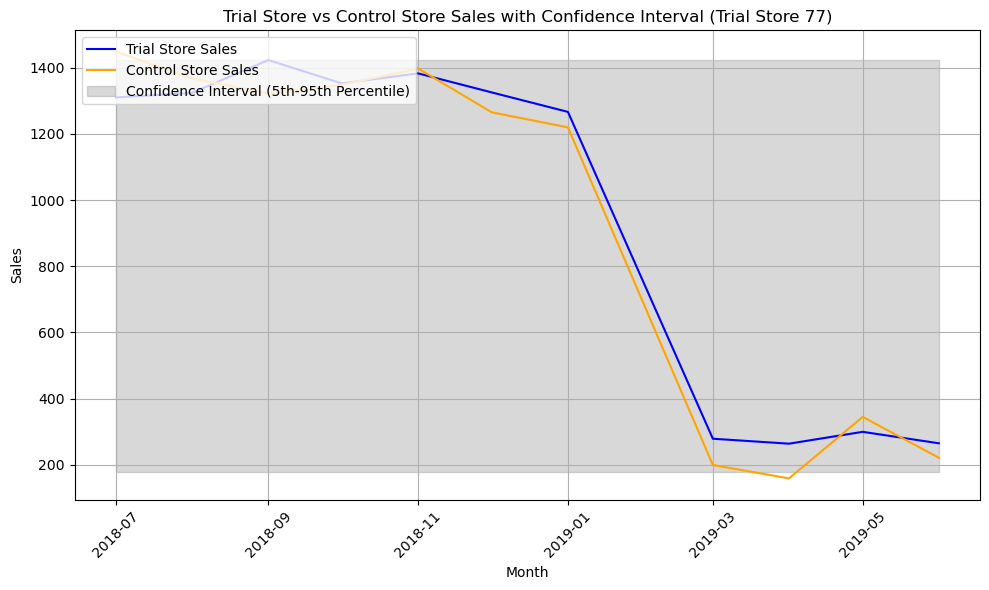

In [176]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trial_vs_control_sales_with_confidence_interval(final_df, trial_store_id):
    """
    Plot the trial store sales, control store sales, and the 5th and 95th percentiles 
    as the confidence interval for the control store sales.
    
    Parameters:
    final_df (pd.DataFrame): DataFrame containing the trial and control store sales and percent differences.
    trial_store_id (int): The trial store identifier to plot.
    """
    # Filter trial store data
    trial_data = final_df[final_df['trial_store'] == trial_store_id]
    
    # Find the control store for this trial store (assuming the 'control_store' column is linked to the trial store)
    control_store_id = trial_data['control_store'].iloc[0]
    
    # Filter control store data based on the control store ID
    control_data = final_df[final_df['control_store'] == control_store_id]
    
    # Merge trial and control data on the 'MONTH' column to align the data by time
    merged_data = pd.merge(trial_data[['MONTH', 'trial_sales']], 
                           control_data[['MONTH', 'control_sales']], 
                           on='MONTH', how='left')
    
    # Calculate the 5th and 95th percentiles for control store sales
    control_5th_percentile = control_data['control_sales'].quantile(0.05)
    control_95th_percentile = control_data['control_sales'].quantile(0.95)

    # Plot the sales for trial store and control store
    plt.figure(figsize=(10, 6))
    
    # Plot trial store sales
    plt.plot(merged_data['MONTH'].dt.to_timestamp(), merged_data['trial_sales'], label='Trial Store Sales', color='blue')
    
    # Plot control store sales
    plt.plot(merged_data['MONTH'].dt.to_timestamp(), merged_data['control_sales'], label='Control Store Sales', color='orange')

    # Plot the confidence interval (5th and 95th percentiles) for control store sales
    plt.fill_between(
        merged_data['MONTH'].dt.to_timestamp(),
        control_5th_percentile, control_95th_percentile,
        color='gray', alpha=0.3, label='Confidence Interval (5th-95th Percentile)'
    )

    # Customize the plot
    plt.xlabel('Month')
    plt.ylabel('Sales')
    plt.title(f'Trial Store vs Control Store Sales with Confidence Interval (Trial Store {trial_store_id})')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example: Plot for trial store with ID 77
plot_trial_vs_control_sales_with_confidence_interval(final_df, trial_store_id=77)


------------------------------